In [1]:
import numpy as np
import matplotlib.pyplot as pl

# Define measurement noise

In [2]:
## System parameters
zeropoint = 2.82e9 # photons/s/m2, Cedric's H-band zeropoint
throughput = 0.55 # Cedric's total throughput, not counting QE
wavelength = 1630e-9 # meters
diameter = 10.0 # meters

## Observation parameters
Hmag = 9.0    # star's H magnitude
freq = 1000.0 # tip/tilt loop speed, Hz

## Compute measurement noise
photons_per_measurement       = zeropoint * 10**(-0.4*Hmag) * (1.0/freq) * (np.pi * (diameter/2)**2) * throughput
measurement_noise_single_axis = wavelength/(np.pi * diameter * np.sqrt(photons_per_measurement)) * 206265 # arcseconds
print('Single axis measurement noise = ', round(measurement_noise_single_axis*1000,2), ' mas')

Single axis measurement noise =  0.06  mas


# Generate a set of XY positions from random vibrations

In [3]:
def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

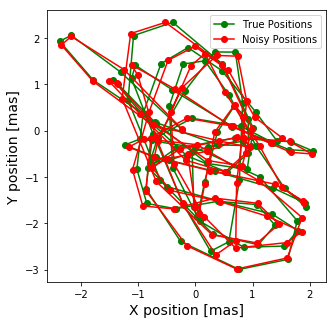

In [4]:
## Define vibrations
N_vibrations = 20 
vib_freqs    = np.random.uniform(low=10.0, high=1000.0, size=N_vibrations)  # Hz
vib_amps     = np.random.uniform(low=0.0001, high=0.001, size=N_vibrations) # arcseconds
vib_phase    = np.random.uniform(low=0.0, high=2*np.pi, size=N_vibrations)  # radians
vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vibrations)  # radians

## Generate a set of XY positions from vibrations
total_time = 120 # seconds
time_steps = np.arange(0, total_time, 1.0/freq)
n_steps = len(time_steps)

true_positions = np.zeros((n_steps,2))
for i in range(N_vibrations):
    y_init_of_t = vib_amps[i] * np.sin(vib_freqs[i] * time_steps - vib_phase[i])
    x_init_of_t = np.zeros(len(time_steps)) 
    positions_init = np.vstack((x_init_of_t, y_init_of_t))
    rotated_positions = np.dot(rotation_matrix(vib_pa[i]) , positions_init)
    true_positions = true_positions + np.transpose(rotated_positions)

## Add measurement noise (white noise)
noisy_positions = true_positions + np.random.normal(loc=0, scale = measurement_noise_single_axis, size = np.shape(true_positions))

## Split positions into the training set and test set
training_true_positions = true_positions[0:60000,:]
training_noisy_positions = noisy_positions[0:60000,:]

test_true_positions = true_positions[60000:120000,:]
test_noisy_positions = noisy_positions[60000:120000,:]

## Plot a 0.1s segment of the data
pl.close("all")
pl.figure(figsize=(5,5))
pl.plot(true_positions[0:100,0]*1000, true_positions[0:100,1]*1000, 'go-', label='True Positions')
pl.plot(noisy_positions[0:100,0]*1000, noisy_positions[0:100,1]*1000, 'ro-', label='Noisy Positions')
pl.xlabel('X position [mas]',fontsize=14)
pl.ylabel('Y position [mas]',fontsize=14)
pl.legend()
pl.show()

# Make the predictive filter

In [5]:
## System parameters
lag = 3 # the tip/tilt loop lag in number of frames

## Filter parameters
m = 2           # degrees of freedom
n = 800         # number of previous measurements included in a single history vector
l = 60000-n-lag # total number of time steps in filter

In [6]:
## Compute D
end_index_D = np.shape(training_noisy_positions)[0]-1-lag
D = np.zeros((n*m, l))
for i in range(l): 
    D[:,i] = np.reshape(training_noisy_positions[end_index_D-i-(n-1):end_index_D+1-i,:][::-1], (n*m))

In [7]:
## Compute P
end_index_P = np.shape(training_noisy_positions)[0]-1
P = np.zeros((m, l))
for i in range(l):
    P[:,i] = np.reshape(training_noisy_positions[end_index_P-i,:], (m))

In [ ]:
## Check that D is lag elements behind P
print('1st element in D = ', D[0:2,0])
print('lag element in P = ', P[0:2,lag])

1st element in D =  [ 0.0005209  -0.00102134]
lag element in P =  [ 0.0005209  -0.00102134]


In [ ]:
## Get the pseudo-inverse of D via SDV (slow) 
D_T = np.transpose(D)
u, s, v_T = np.linalg.svd(D_T)
print('Done with SVD')

s2 = np.zeros((l, m*n), dtype=complex)
s2[:m*n, :m*n] = np.diag(s)
s_inverse_transpose = np.matrix.transpose(np.linalg.pinv(s2))

In [ ]:
## Compute the predictive filter
thefilter = np.dot(P, np.dot(u, np.dot(s_inverse_transpose, v_T))).real

# Apply the predictive filter to the test positions

In [ ]:
number_of_steps = 100 # 0.1 of data
start_index = n # because we need to make a history vector before applying the filter

time_lag_residual  = np.zeros((number_of_steps,2))
no_lag_residual    = np.zeros((number_of_steps,2))
predicted_residual = np.zeros((number_of_steps,2))
prediction         = np.zeros((number_of_steps,2))
for i in np.arange(number_of_steps):
    index = start_index + i
    
    time_lag_residual[i,:] = test_true_positions[index+lag,:] - test_noisy_positions[index,:]
    no_lag_residual[i,:]   = test_true_positions[index+lag,:] - test_noisy_positions[index+lag,:]
    
    history = np.reshape(test_noisy_positions[index-n+1:index+1,:][::-1], (n*m))
    prediction[i,:] = np.dot(thefilter, history).real
    
    predicted_residual[i,:] = test_true_positions[index+lag,:] - prediction[i,:]

In [ ]:
## Plot single axis motion over time
pl.close("all")
pl.figure(figsize=(20,5))
pl.plot(test_noisy_positions[start_index:start_index+number_of_steps,0]*1000, 'go-', label=str(int(lag))+' ms Lag Positions')
pl.plot(test_true_positions[start_index+lag:start_index+number_of_steps+lag,0]*1000, 'ro-', label='True Positions')
pl.plot(prediction[:,0]*1000, 'bo-', markerfacecolor='none', markersize=15, label='Predicted Positions')
pl.xlabel('Frame number',fontsize=14)
pl.ylabel('Position [mas]',fontsize=14)
pl.legend()
pl.show()

In [ ]:
## Plot residuals over time
pl.close("all")
pl.figure(figsize=(10,10))
#pl.plot(time_lag_residual[:,0]*1000, time_lag_residual[:,1]*1000, 'g.-', label=str(int(lag))+' ms time lag residual')
pl.plot(no_lag_residual[:,0]*1000, no_lag_residual[:,1]*1000, 'm.-', label='Zero time lag residual')
pl.plot(predicted_residual[:,0]*1000, predicted_residual[:,1]*1000, 'b.-', label='Predictive residual')
pl.xlabel('X position [mas]',fontsize=14)
pl.ylabel('Y position [mas]',fontsize=14)
pl.legend()
pl.show()

In [ ]:
## Plot residuals over time
pl.close("all")
pl.figure(figsize=(10,10))
pl.plot(no_lag_residual[:,0]*1000, no_lag_residual[:,1]*1000, 'm.-', label='Zero time lag residual')
pl.plot(predicted_residual[:,0]*1000, predicted_residual[:,1]*1000, 'b.-', label='Predictive residual')
pl.xlabel('X position [mas]',fontsize=14)
pl.ylabel('Y position [mas]',fontsize=14)
pl.legend()
pl.show()